<a href="https://colab.research.google.com/github/todebode/Garments-employee-productivity/blob/main/Garment_Industry_Employee_Productivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garment Industry Employee Productivity

Tijesunimi Odebode

03/16/2022

In [657]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import necessary packages

In [658]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

## 2. Load and verify data

In [659]:
filename = '/content/drive/MyDrive/Coding Dojo Bootcamp/Data/garments_worker_productivity.xlsx'
garm_prod = pd.read_excel(filename)
garm_prod.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


## 3. Explore the data

a) Check for missing values. **Note:** Missing values will not be addressed here. Missing values will be addressed further down in the notebook. However, let's check to see the missing vaues.

b) Check for duplicates and address them

### a) Check for missing values.

In [660]:
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    691 non-null    float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

- There are 1197 rows and 15 columns. There is missing data in the **'wip'** column considering there are only 691 non-null values.

### b) Check for duplicates and address them

In [661]:
# Identify and address any duplicates
garm_prod.duplicated().sum()

0

- There are no duplicates in the dataset

In [662]:
garm_prod

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,2015-03-11,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,2015-03-11,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


### c) Let's check the datatypes and ensure they are all correct

In [663]:
gpdata_types = garm_prod.dtypes
gpdata_types

date                     datetime64[ns]
quarter                          object
department                       object
day                              object
team                              int64
targeted_productivity           float64
smv                             float64
wip                             float64
over_time                         int64
incentive                         int64
idle_time                       float64
idle_men                          int64
no_of_style_change                int64
no_of_workers                   float64
actual_productivity             float64
dtype: object

- All the datatypes seeem to be correct.

### d) Check for other errors/issues with the data and fix them

In [664]:
# Let's check the statistics for the numerical columns
garm_prod.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


- It looks like the 'actual_productivity' column has a maximum value of approximately 1.120. Based on the attribute information given on the dataset reference page (https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees#), 'actual_productivity' should range between 0 and 1. 

Let's check how many rows contain a value greater than 1 in the 'actual_productivity' column.

In [665]:
# Let's see how many rows contain actual_productivity > 1
prod_filter = garm_prod['actual_productivity']>1
prod_filter.sum()

37

In [666]:
# Let's create a filter for actual_productivity < or = 1 
# This should delete rows with actual_productivity > 1
prod1_filter = garm_prod['actual_productivity'] <= 1
garm_prod = garm_prod.loc[prod1_filter, :]

In [667]:
# Let's confirm that rows with actual_productivity > 1 have been dropped
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1160 non-null   datetime64[ns]
 1   quarter                1160 non-null   object        
 2   department             1160 non-null   object        
 3   day                    1160 non-null   object        
 4   team                   1160 non-null   int64         
 5   targeted_productivity  1160 non-null   float64       
 6   smv                    1160 non-null   float64       
 7   wip                    666 non-null    float64       
 8   over_time              1160 non-null   int64         
 9   incentive              1160 non-null   int64         
 10  idle_time              1160 non-null   float64       
 11  idle_men               1160 non-null   int64         
 12  no_of_style_change     1160 non-null   int64         
 13  no_

- We now have 1160 rows instead of 1197 previously. This confirms that 37 rows have been dropped.

In [668]:
# Let's drop the 'date' column
garm_prod.drop(columns=['date'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [669]:
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1160 non-null   object 
 1   department             1160 non-null   object 
 2   day                    1160 non-null   object 
 3   team                   1160 non-null   int64  
 4   targeted_productivity  1160 non-null   float64
 5   smv                    1160 non-null   float64
 6   wip                    666 non-null    float64
 7   over_time              1160 non-null   int64  
 8   incentive              1160 non-null   int64  
 9   idle_time              1160 non-null   float64
 10  idle_men               1160 non-null   int64  
 11  no_of_style_change     1160 non-null   int64  
 12  no_of_workers          1160 non-null   float64
 13  actual_productivity    1160 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 135.9+ 

- There are now 14 columns. This confirms that the 'date' column has been dropped

### 4) Identify each feature as numerical, ordinal, or nominal.

**Numerical features:** 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'

**Nominal features:** 'quarter', 'department', 'day'

**Ordinal features:** There are no ordinal features

### 5) Find and Fix inconsistent categories of data in the nominal feature columns

In [670]:
# Let's assign a variable to columns that are just 'object' datatypes
obj_col = gpdata_types[gpdata_types=='object'].index
obj_col

Index(['quarter', 'department', 'day'], dtype='object')

In [671]:
# Let's loop through 'object' columns and see the unique values and counts in all 'object' columns
for x in obj_col:
    print(f'- {x}:')
    print(garm_prod[x].value_counts(dropna=False))
    print()

- quarter:
Quarter1    348
Quarter2    324
Quarter4    243
Quarter3    204
Quarter5     41
Name: quarter, dtype: int64

- department:
sweing        666
finishing     253
finishing     241
Name: department, dtype: int64

- day:
Wednesday    200
Sunday       196
Monday       195
Tuesday      194
Thursday     193
Saturday     182
Name: day, dtype: int64



- We can see from the above that

a) There are no inconsistent categories of data in the 'day' column.

b) There are no inconsistent categories of data in the 'quarter' column.

c) In the 'department' column, it seems like there are two unique ways the word 'finishing' appears. However, it is not exactly obvious why this is so. Both words seem to be spelt correctly and the same way. 

Let's see the unique values a different way.

In [672]:
# Let's see the unique values in the 'department' column
garm_prod['department'].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

- It is obvious from the above that in one case, 'finishing' is written with a white space after the word. So, the word appears in two ways: 'finishing ' and 'finishing'.

In [673]:
# We can make 'finishing ' appear as 'finishing'
garm_prod['department'] = garm_prod['department'].replace('finishing ','finishing')
dept_replace = garm_prod['department'].unique()
dept_replace.sort()
dept_replace

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['finishing', 'sweing'], dtype=object)

- All inconsistent 'finishing' have been corrected

In [674]:
# Let's run value_counts also to confirm
garm_prod['department'].value_counts()

sweing       666
finishing    494
Name: department, dtype: int64

- We now have a total count of 494 (253 + 241) for the word 'finishing'

In [675]:
garm_prod

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


### 6) Create univariate visualizations. 

a) Barchart of 'department' column. We will plot the count of each department

b) Histogram of 'targeted_productivity' column. The 'targeted_productivity' column represents targeted productivity set by the authority for each team for each day.

c) Histogram of 'actual_productivity' column. The 'actual_productivity' column represents the actual % of productivity that was delivered by the workers. 

a) Barchart of 'department' column. 

In [676]:
# Count each department listed in the 'department' column
dept_counts = garm_prod['department'].value_counts()
dept_counts

sweing       666
finishing    494
Name: department, dtype: int64

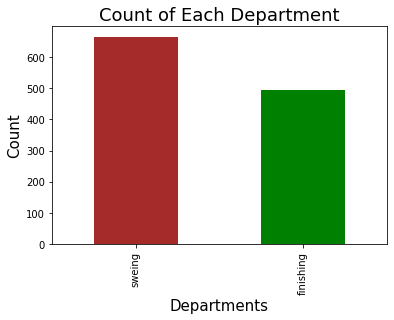

sweing       666
finishing    494
Name: department, dtype: int64

In [677]:
# Plot the counts of each department

dept_counts.plot(kind = 'bar', color = ['brown','green'])
plt.title('Count of Each Department', fontsize = 18)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Departments', fontsize = 15)

# Show your figure
plt.show()

# Display the counts below the plot
dept_counts

- We can see from the above bar chart that the department 'sweing' had a higher count. There was more data obtained from the sweing department than the finishing department.

b) Histogram of 'targeted_productivity' column. 

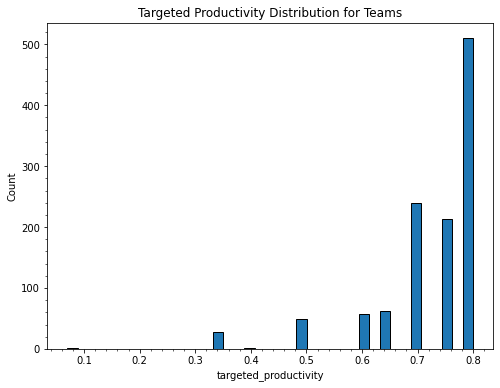

In [678]:
# Histogram of Targeted Productivity distribution.
plt.figure(figsize=(8,6))
# Parameter "edgecolor='black'" was adapted from: https://www.youtube.com/watch?v=XDv6T4a0RNc&list=PL-osiE80TeTvipOqomVEeZ1HRrcEvtZB_&index=6
plt.hist(garm_prod['targeted_productivity'], bins='auto', edgecolor='black')
plt.xlabel("targeted_productivity")
plt.ylabel("Count")
plt.title("Targeted Productivity Distribution for Teams")
# "The following Code adapted from: https://stackoverflow.com/questions/9127434/how-to-create-major-and-minor-gridlines-with-different-linestyles-in-python”
plt.minorticks_on();

- From the above histogram, targeted productivity frequency for workers was highest around approximately 0.78 - 0.80 or 78% - 80% range. This means that the number of times work teams were given set target productivity between 78% - 80% range was highest of all target productivity ranges. Since this range is the highest of all, we can say that employers expected high productivity from workers most days.

c) Histogram of 'actual_productivity' column.

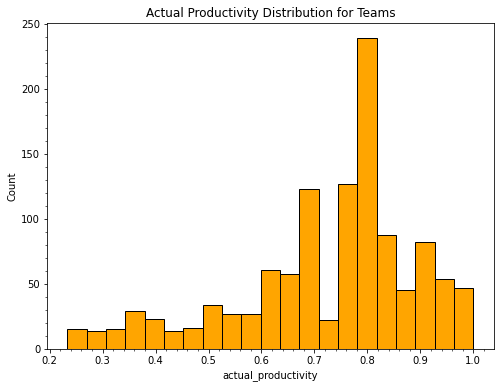

In [679]:
# Histogram of Targeted Productivity distribution.
plt.figure(figsize=(8,6))
# Parameter "edgecolor='black'" was adapted from: https://www.youtube.com/watch?v=XDv6T4a0RNc&list=PL-osiE80TeTvipOqomVEeZ1HRrcEvtZB_&index=6
plt.hist(garm_prod['actual_productivity'], color = 'orange', bins='auto', edgecolor='black')
plt.xlabel("actual_productivity")
plt.ylabel("Count")
plt.title("Actual Productivity Distribution for Teams")
# "The following Code adapted from: https://stackoverflow.com/questions/9127434/how-to-create-major-and-minor-gridlines-with-different-linestyles-in-python”
plt.minorticks_on();

- From the above histogram, actual productivity frequency for workers was highest around approximately 0.78 - 0.82 or 78% - 82% range. This means that the number of times actual percent productivity for work teams fell between 78% - 82% range was highest of all actual productivity ranges. Since this range is close to the target productivity range (78% - 80%) with highest frequency, we can say that the target productivity was met by work teams most of the time.

### 7) Identify Outliers

In [680]:
# Let's check the statistics for the numerical columns
garm_prod.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1160.000000,1160.000000,1160.00000,666.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000
mean,6.544828,0.727905,15.01481,1159.974474,4575.301724,37.012931,0.753448,0.381034,0.155172,34.346552,0.725991
std,3.422968,0.098735,11.00475,1769.132478,3363.475857,162.300882,12.910356,3.320081,0.433766,22.181174,0.169404
min,1.000000,0.070000,2.90000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,4.000000,0.700000,3.94000,762.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650061
50%,7.000000,0.750000,15.26000,1028.500000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.754425
75%,9.000000,0.800000,24.26000,1226.750000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.845167
max,12.000000,0.800000,54.56000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,0.999995


- To determine the outliers in our data, I would have to use a data visualization technique. I have decided to use boxplots. First, I will look at the above summary statistics (found using '.describe'), and then look at the median of each column to see if it is halfway in the middle of all the values. If the median is around halfway of all the values, then there is a chance that column does not have an outlier. Secondly, if the maximum is far away from the 75% (75th percentile) value, there is a chance that column has an outlier. Finally, if the minimum is far away from the 25% (25th percentile) value, there is a chance that column has an outlier. I have selected columns after considering the above 3 criteria stated and decided to create boxplots for each of those columns below.

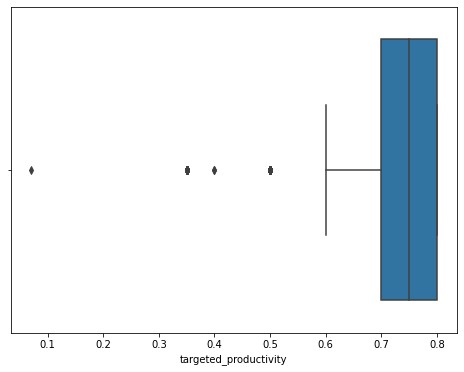

In [681]:
# Boxplot for 'targeted_productivity' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='targeted_productivity');

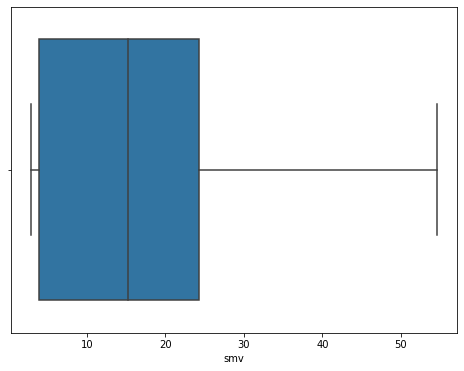

In [682]:
# Boxplot for 'smv' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='smv');

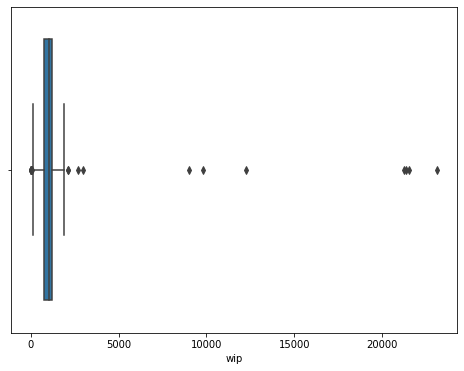

In [683]:
# Boxplot for 'wip' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='wip');

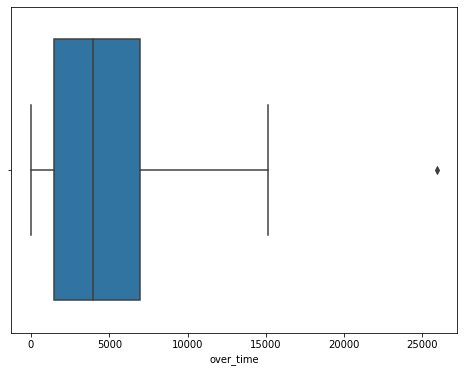

In [684]:
# Boxplot for 'over_time' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='over_time');

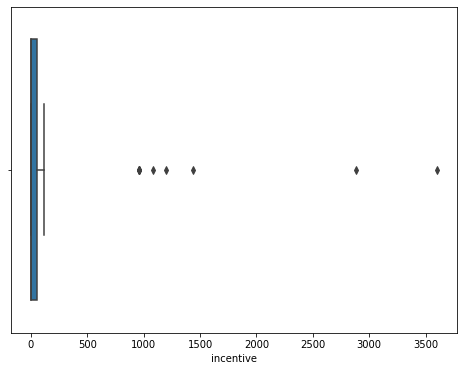

In [685]:
# Boxplot for 'incentive' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='incentive');

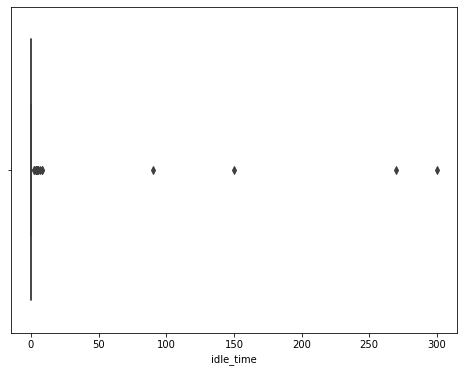

In [686]:
# Boxplot for 'idle_time' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='idle_time');

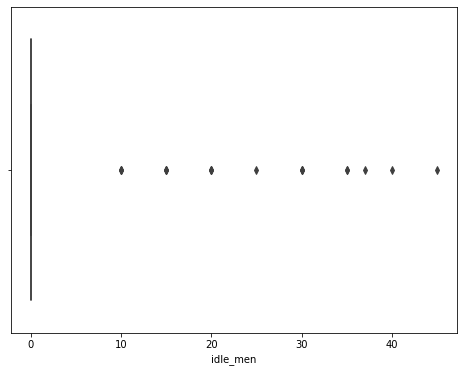

In [687]:
# Boxplot for 'idle_men' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='idle_men');

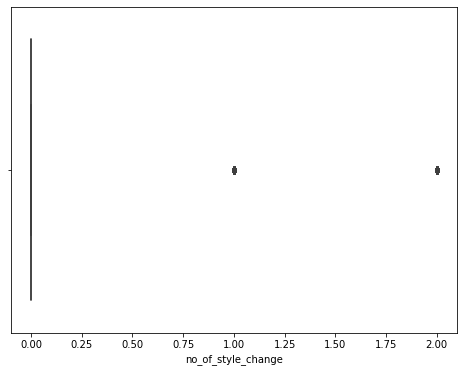

In [688]:
# Boxplot for 'no_of_style_change' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='no_of_style_change');

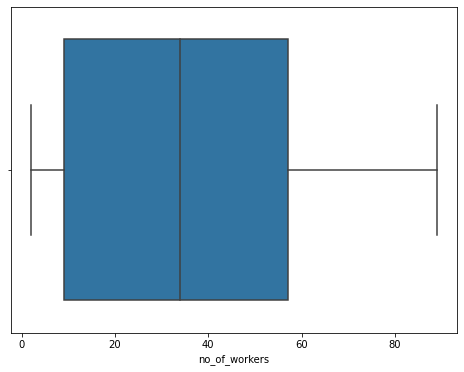

In [689]:
# Boxplot for 'no_of_workers' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='no_of_workers');

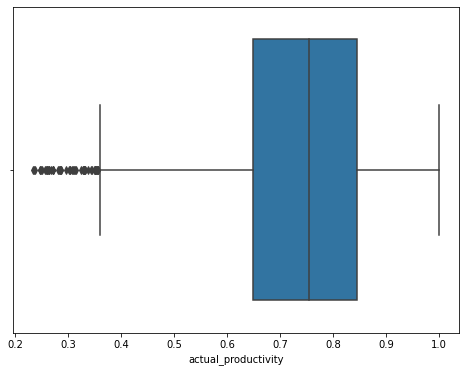

In [690]:
# Boxplot for 'actual_productivity' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='actual_productivity');

- We can see from the above boxplots that the following columns have outliers in them: 'targeted_productivity', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', and 'actual_productivity.'

- I have decided to keep the outliers in the 'garm_prod' data because I see no reason to believe they are errors in the dataset.

### 8) Correlation heatmap of the 'garm_prod' dataframe

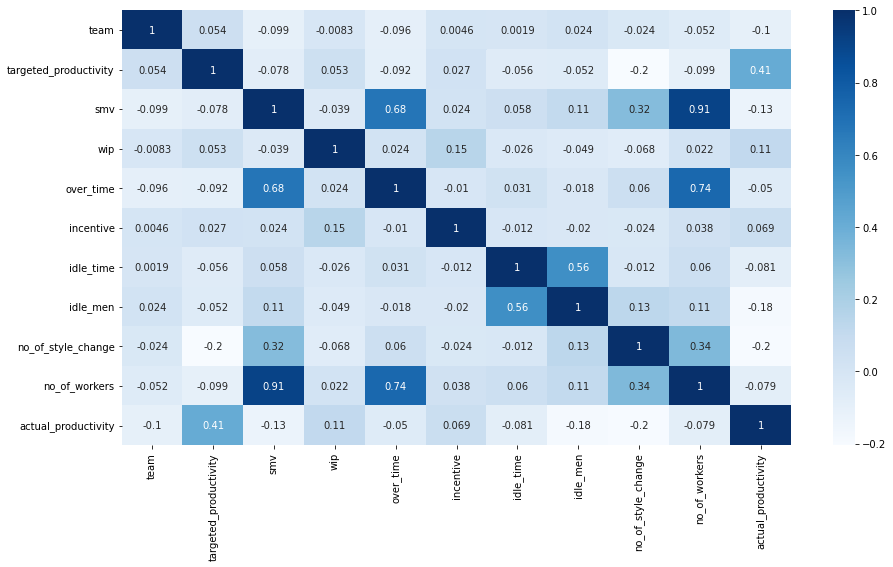

In [691]:
# Heat map of the 'garm_prod' dataframe
corr = garm_prod.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, cmap='Blues', annot=True);

- Low positive correlation coefficients are roughly between 0.3 and 0.5. Low negative correlation coefficients are roughly between -0.3 and -0.5.

- Moderate positive correlation coefficients are between 0.5 and 0.7. Moderate negative correlation coefficients are roughly between -0.5 and -0.7.

- Strong correlation coefficients are between 0.7 and 1. Strong negative correlation coefficients are between -0.7 and -1.

- In general, the closer the correlation coefficient is to 0, the weaker the correlation.

- The following are the moderate and strong correlations in the data:

**Moderate positive Correlations:**

- 'smv' and 'over_time': Correlation Coefficient is 0.68  

- 'over_time' and 'no_of_workers': Correlation Coefficient is 0.74

- 'idle_time' and 'idle_men': Correlation Coefficient is 0.56

**Strong positive Correlations:**

- 'smv' and 'no_of_workers': Correlation Coefficient is 0.91

There are no moderate or strong negative correlations


### 9) Validation Split

In [692]:
X = garm_prod.drop(columns=['actual_productivity'])
y = garm_prod['actual_productivity']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### 10) Instantiate Column Selectors

In [693]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

### 11) Instantiate Transformers.

We will be using 3 different transformers: SimpleImputer, StandardScaler, and OneHotEncoder. There will be one SimpleImputer with one imputation strategy: ‘median’ strategy for numeric columns. There is no categorical feature with missing value, so we won't need to use SimpleImputer for categorical columns. We will one-hot encode the nominal categorical features as well.

In [694]:
# Imputers
median_imputer = SimpleImputer(strategy='median')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

### 12) Instantiate Pipelines

We will be using ONE pipeline for numeric data.

In [695]:
# Numeric pipeline
numeric_pipe = make_pipeline(median_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### 13) Instantiate ColumnTransformer

In [696]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (ohe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa41da55550>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa41da55b50>)])

- We only one-hot encode nominal features. The cat_selector selects nominal categorical features before they are one-hot encoded in this section. We did not have ordinal features. If we did, we would have ordinal encoded the ordinal features. Ordinal features are ordered categorical features. Nominal features are unordered categorical features. Since computational modeling can only model numbers, we need to convert categorical data to numeric form by ordinal encoding ordinal features and one-hot encoding nominal features.

### 14) Fit the ColumnTransformer on the training data and transform both training and testing data

In [697]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa41da55550>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa41da55b50>)])

In [698]:
# transform training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### 15) Inspect the Result

In [699]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (870, 23)




array([[-1.60256251,  0.22079175, -0.9915077 , ...,  0.        ,
         1.        ,  0.        ],
       [-0.44312019,  0.22079175, -0.9724977 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.60256251,  0.71637696,  0.69042539, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.31270193, -0.27479345,  0.10926228, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.71632212, -0.27479345,  0.35277143, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71632212,  0.22079175,  0.35277143, ...,  0.        ,
         1.        ,  0.        ]])

- From the above, we see that there are no missing data, all data are of type float64, and there are 23 columns.